# **1. 데이터 차원**
- 데이터 자체는 충분함
- 불균형 데이터 -> Data Augmentation
- 데이터 범위(scale) 조정: 정규화/규제화/표준화

# **2. 알고리즘 차원**
- 진단
    - train/ valid 모두 accuracy가 그다지 높지 않음 -> Epoch을 증가시켜 다시 학습 진행 
    - 과적합 방지를 위한 기법들 도입하기(드롭아웃, 조기 종료)
- 가중치
    - AutoEncoder 등과 같은 비지도 학습을 통해 사전 훈련
    - 이후 다시 지도 학습 진행
- 학습률(learning rate)
    - Learning rate Scheduling 적용
- 활성화 함수/손실함수
    - 활성화 함수: softmax
    - 손실 함수: CrossEntropyLoss
    - 활성화 함수 변경 시 손실 함수도 함께 변경해야 하는 경우가 많음 -> 주의
- 배치/ Epoch
    - DataLoader에서 batch size 조정(batch_size = 32 or 64) --- ?
    - Epoch: 과소적합의 경향성 -> 100으로 증가

# **3. 하드웨어 차원**
- 역전파처럼 복잡한 미적분 연산의 경우 병렬 연산을 해야 속도/ 정확도 증가
- 장치를 cpu에서 gpu로 변경

In [1]:
### 필요한 라이브러리 준비

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy
import argparse

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact
from module.pytorchtools import EarlyStopping # 사용자 정의 모듈
                                              # 외부 py파일을 모듈로 import하여 EarlyStopping 함수 사용

In [2]:
### gpu 장치 확인
print(torch.__version__) 
print(torch.cuda.get_device_name(0))

1.12.1+cu116
NVIDIA GeForce GTX 1660 SUPER


### **DataLoader**

In [3]:
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

# 분류에 사용할 class 정의(7개의 감정들)
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [4]:
IMAGE_SIZE = 48

### 이미지 파일 경로를 리스트 형태로 저장하기 위한 함수
def list_image_file(data_dir,sub_dir):
    image_files = []
    
    images_dir = os.path.join(data_dir,sub_dir)
    for file_path in os.listdir(images_dir):
        image_files.append(os.path.join(sub_dir,file_path))
    return image_files

In [5]:
### 학습 데이터셋 클래스
class Feeling_dataset(Dataset):
    ### 생성자
    def __init__(self,data_dir,transform = None):
        self.data_dir = data_dir # 데이터가 저장된 상위 directory
        angry_imgs = list_image_file(data_dir,'angry')
        disgust_imgs = list_image_file(data_dir,'disgust')
        fear_imgs = list_image_file(data_dir,'fear')
        happy_imgs = list_image_file(data_dir,'happy')
        neutral_imgs = list_image_file(data_dir,'neutral')
        sad_imgs = list_image_file(data_dir,'sad')
        surprise_imgs = list_image_file(data_dir,'surprise')
        
        # 모든 사진들의 경로를 하나의 리스트에 저장
        self.files_path = angry_imgs + disgust_imgs + fear_imgs + happy_imgs + neutral_imgs + sad_imgs + surprise_imgs
        self.transform = transform
    
    ### 데이터 개수 확인
    def __len__(self):
        return len(self.files_path) # 전체 데이터 개수
    
    ### getitem
    def __getitem__(self,index):
        # image(feature data)
        image_file = os.path.join(self.data_dir,self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.resize(image,dsize = (IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # feeling(target data)
        target = feelings_list.index(self.files_path[index].split(os.sep)[0])
        
        if self.transform:
            image = self.transform(image) # feature data에 대해서만 데이터 변형 수행
            target = torch.Tensor([target]).long()
            
        return {'image':image,'target':target}

In [6]:
### Transformation

# 학습 feature data 변환
train_transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 수평으로 뒤집기
    transforms.RandomVerticalFlip(), # 수직으로 뒤집기
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

# 검증 feature data 변환
val_transformer = transforms.Compose([
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

In [7]:
### 데이터로더 구현
def build_dataloader(train_data_dir,val_data_dir):
    dataloaders = {}
    train_dset = Feeling_dataset(train_data_dir,train_transformer)
    dataloaders['train'] = DataLoader(train_dset,batch_size = 64,shuffle = True,drop_last = True)
    
    val_dset = Feeling_dataset(val_data_dir,val_transformer)
    dataloaders['val'] = DataLoader(val_dset,batch_size = 64,shuffle = False,drop_last = False)
    
    return dataloaders

- batch size 조정 필요

In [8]:
train_data_dir = './DataSet/archive/train/'
val_data_dir = train_data_dir = './DataSet/archive/valid/'
dataloaders = build_dataloader(train_data_dir,val_data_dir)

### **Modeling**

In [9]:
from torchsummary import summary

In [10]:
### 모델 생성 함수
# 기존의 VGG19 모델 호출 -> head 부분 수정
def build_vgg19_based_model():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = models.vgg19(pretrained = True) # 이미 학습된 vgg19 모델 불러오기
    # 일반 NN Layer(FC Layer)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1)) # 각 구역의 평균값 출력
    model.classifier = nn.Sequential(
        nn.Flatten(), # 평탄화
        nn.Linear(512,256), # 512 -> 256
        nn.ReLU(), # 활성화 함수
        nn.Dropout(0.1), # 과적합 방지
        nn.Linear(256,7), # 256 -> 7(7개의 감정으로 분류되니)
        nn.Softmax() # 활성화 함수(각 클래스에 속할 확률 추정)
    )
    
    return model.to(device)

### **Estimation**

In [11]:
### 모델 검증을 위한 accuracy

@torch.no_grad() 
def get_accuracy(image,target,model):
    batch_size = image.shape[0] 
    prediction = model(image) # 예측 
    _,pred_label = torch.max(prediction,dim = 1) # 예측이 어느 클래스에 속하는지 확률이 가장 높은 1개 선택
    is_correct = (pred_label == target)
    
    return is_correct.cpu().numpy().sum() / batch_size

### **Training**

In [12]:
### Epoch을 1번 수행
def train_one_epoch(dataloaders,model,optimizer,loss_func,device):
    losses = {} # loss값 저장
    accuracies = {} # 정확도 값 저장
    
    for tv in ['train','val']:
        ### loss, accuracy를 계속 갱신
        running_loss = 0.0
        running_correct = 0
        
        if tv == 'train': # 학습
            model.train()
        else: # 검증
            model.eval()
        
        for index,batch in enumerate(dataloaders[tv]):
            image = batch['image'].to(device) # feature data(이미지)
            target = batch['target'].squeeze(dim = 1).to(device) # label data(감정), 1차원으로 차원 축소 진행
            
            ### 역전파 적용
            with torch.set_grad_enabled(tv == 'train'): 
                prediction = model(image) # label 예측
                loss = loss_func(prediction,target) # loss값 계산
                
                if tv == 'train':
                    optimizer.zero_grad() # 한 번의 학습 완료 -> gradient를 0으로 초기화
                    loss.backward() # 역전파
                    optimizer.step() # 가중치 업데이트
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image,target,model)
            
            if tv == 'train':
                if index % 50 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
        losses[tv] = running_loss / len(dataloaders[tv])
        accuracies[tv] = running_correct / len(dataloaders[tv])
    return losses, accuracies

In [13]:
### 학습이 잘 된 모델 저장
def save_best_model(model_state,model_name,save_dir = './best_model'):
    os.makedirs(save_dir,exist_ok = True) # 경로 존재 시 덮어쓰기, 없는 경우 새로 생성
    torch.save(model_state,os.path.join(save_dir,model_name)) # 모델 저장

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 장치 얻어오기

### 경로 설정
train_data_dir = './DataSet/archive/train/'
val_data_dir = './DataSet/archive/valid/'

### 필요한 요소들 준비
dataloaders = build_dataloader(train_data_dir,val_data_dir)
model = build_vgg19_based_model()
loss_func = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-2,momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 5, factor = 0.1,
                                                       min_lr = 1e-10,verbose = True)  # lr scheduling
early_stopping = EarlyStopping(patience = 10, verbose = False) # 조기 종료(사용자 정의 모듈)

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
num_epochs = 100

best_acc = 0.0
train_loss,train_accuracy = [],[]
val_loss,val_accuracy = [],[]

for epoch in range(num_epochs):
    ### 1 Epoch 수행
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    
    ### LR Scheduling
    scheduler.step(losses['val']) # 1 Epoch 수행 후 learning rate 조정
    # EarlyStopping
    early_stopping(losses['val'], model) # 현재 과적합 상황 추적
    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        break
        
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_accuracy.append(accuracies['train'])
    val_accuracy.append(accuracies['val'])
    
    print(f"{epoch+1}/{num_epochs}-Train Loss:{losses['train']}, Val Loss:{losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc:{accuracies['train']}, Val Acc:{accuracies['val']}")
    
    # deepcopy: 배열의 내부 객체까지 복사를 해서 사용
    # copy: 배열의 내부 객체까지 깊은 복사를 해주지 않음
    if (epoch > 3) and (accuracies['val'] > best_acc):
        best_acc = accuracies['val']
        best_model = copy.deepcopy(model.state_dict()) 
        save_best_model(best_model, f'model_{epoch+1:02d}.pth')

print(f'Bset Accuracy: {best_acc}')

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0/455 - Running loss: 1.948347806930542
50/455 - Running loss: 1.9122796058654785
100/455 - Running loss: 1.774267315864563
150/455 - Running loss: 1.7480955123901367
200/455 - Running loss: 1.6546708345413208
250/455 - Running loss: 1.7251486778259277
300/455 - Running loss: 1.7758647203445435
350/455 - Running loss: 1.723460078239441
400/455 - Running loss: 1.712172269821167
450/455 - Running loss: 1.7347924709320068
1/100-Train Loss:1.769570508632031, Val Loss:1.7449358220685993
1/100-Train Acc:0.40013736263736266, Val Acc:0.40374572554267024
0/455 - Running loss: 1.688657283782959
50/455 - Running loss: 1.6549246311187744
100/455 - Running loss: 1.6227784156799316
150/455 - Running loss: 1.7595007419586182
200/455 - Running loss: 1.8347162008285522
250/455 - Running loss: 1.657690167427063
300/455 - Running loss: 1.7217289209365845
350/455 - Running loss: 1.7621151208877563
400/455 - Running loss: 1.7227591276168823
450/455 - Running loss: 1.7214101552963257
2/100-Train Loss:1.7118

300/455 - Running loss: 1.5932108163833618
350/455 - Running loss: 1.5474932193756104
400/455 - Running loss: 1.8040034770965576
450/455 - Running loss: 1.6412795782089233
EarlyStopping counter: 4 out of 10
15/100-Train Loss:1.6140912545906319, Val Loss:1.624742215139824
15/100-Train Acc:0.5651785714285714, Val Acc:0.5362910719595599
0/455 - Running loss: 1.6593786478042603
50/455 - Running loss: 1.584194302558899
100/455 - Running loss: 1.6376104354858398
150/455 - Running loss: 1.683193325996399
200/455 - Running loss: 1.5516455173492432
250/455 - Running loss: 1.6140652894973755
300/455 - Running loss: 1.5559784173965454
350/455 - Running loss: 1.5519680976867676
400/455 - Running loss: 1.5938762426376343
450/455 - Running loss: 1.5408704280853271
EarlyStopping counter: 5 out of 10
16/100-Train Loss:1.6170510150574067, Val Loss:1.6261474835245233
16/100-Train Acc:0.5639423076923077, Val Acc:0.5361516874814154
0/455 - Running loss: 1.532806634902954
50/455 - Running loss: 1.621307253

350/455 - Running loss: 1.481393575668335
400/455 - Running loss: 1.589635968208313
450/455 - Running loss: 1.5338757038116455
29/100-Train Loss:1.541443417098496, Val Loss:1.5683145188448722
29/100-Train Acc:0.6245879120879121, Val Acc:0.5928532931906036
0/455 - Running loss: 1.4842772483825684
50/455 - Running loss: 1.409637212753296
100/455 - Running loss: 1.53172767162323
150/455 - Running loss: 1.468442440032959
200/455 - Running loss: 1.5081042051315308
250/455 - Running loss: 1.5379235744476318
300/455 - Running loss: 1.5252782106399536
350/455 - Running loss: 1.478314757347107
400/455 - Running loss: 1.459323763847351
450/455 - Running loss: 1.5230529308319092
30/100-Train Loss:1.5362410322650448, Val Loss:1.5654686710290742
30/100-Train Acc:0.629842032967033, Val Acc:0.592328278322926
0/455 - Running loss: 1.5169658660888672
50/455 - Running loss: 1.557137370109558
100/455 - Running loss: 1.5014206171035767
150/455 - Running loss: 1.6002033948898315
200/455 - Running loss: 1.4

50/455 - Running loss: 1.5962741374969482
100/455 - Running loss: 1.5709636211395264
150/455 - Running loss: 1.5273375511169434
200/455 - Running loss: 1.5408128499984741
250/455 - Running loss: 1.5060850381851196
300/455 - Running loss: 1.5348001718521118
350/455 - Running loss: 1.5271642208099365
400/455 - Running loss: 1.440269112586975
450/455 - Running loss: 1.4935685396194458
44/100-Train Loss:1.4958488288816514, Val Loss:1.5537079175313313
44/100-Train Acc:0.6698832417582418, Val Acc:0.6093006616116563
0/455 - Running loss: 1.5271302461624146
50/455 - Running loss: 1.5604802370071411
100/455 - Running loss: 1.4613522291183472
150/455 - Running loss: 1.4967166185379028
200/455 - Running loss: 1.508406400680542
250/455 - Running loss: 1.4904659986495972
300/455 - Running loss: 1.45367431640625
350/455 - Running loss: 1.545788049697876
400/455 - Running loss: 1.4936350584030151
450/455 - Running loss: 1.51217520236969
45/100-Train Loss:1.4949488616251683, Val Loss:1.553016754618862

50/455 - Running loss: 1.5505943298339844
100/455 - Running loss: 1.4889224767684937
150/455 - Running loss: 1.485763669013977
200/455 - Running loss: 1.4287314414978027
250/455 - Running loss: 1.4781790971755981
300/455 - Running loss: 1.4028031826019287
350/455 - Running loss: 1.5504275560379028
400/455 - Running loss: 1.505566120147705
450/455 - Running loss: 1.4419119358062744
EarlyStopping counter: 7 out of 10
58/100-Train Loss:1.4911264665834196, Val Loss:1.5527667183625071
58/100-Train Acc:0.6741071428571429, Val Acc:0.6106480449003866
0/455 - Running loss: 1.5064129829406738
50/455 - Running loss: 1.469001293182373
100/455 - Running loss: 1.4130034446716309
150/455 - Running loss: 1.5563209056854248
200/455 - Running loss: 1.476863980293274
250/455 - Running loss: 1.4433692693710327
300/455 - Running loss: 1.4439483880996704
350/455 - Running loss: 1.4466463327407837
400/455 - Running loss: 1.5108492374420166
450/455 - Running loss: 1.4758319854736328
EarlyStopping counter: 8 o

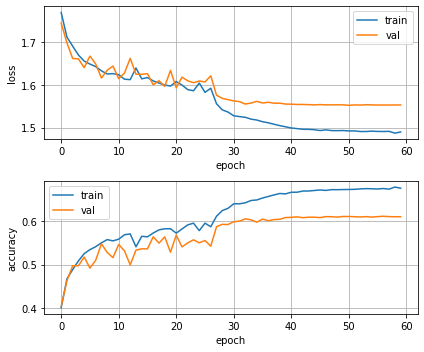

In [16]:
### Loss, Accuracy 시각화

plt.figure(figsize = (6,5))

# Loss
plt.subplot(211)
plt.plot(train_loss,label = "train")
plt.plot(val_loss,label = "val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()

# Accuracy
plt.subplot(212)
plt.plot(train_accuracy,label = "train")
plt.plot(val_accuracy,label = "val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()

plt.tight_layout()